In [1]:
import numpy as N
import pylab as M, matplotlib.pyplot as plt

In [2]:
numsnaps=64
numfiles=256
nparticles=1024
boxsize=1000.

In [3]:
datadir = '/home/idies/workspace/indra/2_0_0/'

In [4]:
snapnum = 63
sn = "%03d" % snapnum
filename = datadir+'/snapdir_'+sn+'/snapshot_'+sn+'.'

In [5]:
pos = N.empty((nparticles**3,3),N.float32)
vel = N.empty((nparticles**3,3),N.float32)
ids = N.empty((nparticles**3),N.int64)
istart = 0
for i in N.arange(0, numfiles):
    file=filename+str(i)
    f=open(file, 'rb')
    
    header_size = N.fromfile(f,N.int32,1)[0] # = 256: error catch here?
    numpart = N.fromfile(f,N.int32,6)
    npart = numpart[1] # number of particles in this file
    mass = N.fromfile(f,N.float64,6)
    pmass = mass[1] # in units of 10^10 solar masses?
    scalefact,redshift = N.fromfile(f,N.float64,2)
    flag_sfr,flag_feedback = N.fromfile(f,N.int32,2)
    numpart_tot = N.fromfile(f,N.int32,6)
    ntotal = numpart_tot[1]
    flag_cooling,num_files = N.fromfile(f,N.int32,2)
    boxsize,omega0,omegal,hubble = N.fromfile(f,N.float64,4)
    flag_stellarage,flag_metals,hashtabsize = N.fromfile(f,N.int32,3)
    # read rest of header_size + 2 dummy integers:
    dummy = N.fromfile(f,N.int32,23)
    
    thispos = N.fromfile(f,N.float32,3*npart)
    thispos = N.reshape(thispos, [npart, 3])
#    thispos = thispos.astype(N.float) # needed?
    
    # read velocities
    dummy = N.fromfile(f,N.int32,2)
    thisvel = N.fromfile(f,N.float32,3*npart)
    thisvel = N.reshape(thisvel, [npart, 3])

    # read IDs
    dummy = N.fromfile(f,N.int32,2)
    thisID = N.fromfile(f,N.int64,npart)
    
    f.close()
    
    pos[istart:(istart+npart),:] = thispos
    vel[istart:(istart+npart),:] = thisvel
    ids[istart:(istart+npart)] = thisID
    
    istart = istart + npart

print 'finished reading particles'

finished reading particles


In [6]:
# Sort pos and vel by the particle IDs (takes a while)
index = N.argsort(ids)
pos = pos[index]
vel = vel[index]
#ids = ids[index]-1

In [7]:
tabfile = datadir+'/snapdir_'+sn+'/group_tab_'+sn+'.'
idsfile = datadir+'/snapdir_'+sn+'/group_ids_'+sn+'.'

In [8]:
# Read group_tab: gives # particles in each halo (groupLen)
file = tabfile+str(0)
f = open(file,'rb')
Ngroups, Nids, TotNgroups, NTask = N.fromfile(f, N.int32, 4)
f.close()
groupLen = N.zeros(TotNgroups,dtype=N.int32)
groupOffset = N.zeros(TotNgroups,dtype=N.int32) # IGNORE? (define later from groupLen... or want initial zeros...)

# Don't read if no groups...
if TotNgroups > 0:
# loop through numfiles
    istart = 0
    for i in N.arange(0, NTask):
        file=tabfile+str(i)
        f=open(file, 'rb')
    
        Ngroups, Nids, TotNgroups, NTask = N.fromfile(f, N.int32, 4)
        if Ngroups > 0:
            locLen = N.fromfile(f,N.int32,Ngroups)
            locOffset = N.fromfile(f,N.int32,Ngroups) # SKIP THIS?
            groupLen[istart:(istart+Ngroups)] = locLen
            groupOffset[istart:(istart+Ngroups)] = locOffset #SKIP THIS?
            istart = istart + Ngroups
        else: print 'No groups in file %d' % i
        f.close()
print 'finished reading halo table'

finished reading halo table


In [9]:
# Offsets not correct, but can redefine using groupLen (probably shouldn't read in first place)
groupOffset = N.zeros(TotNgroups,dtype=N.int32)
groupOffset[1:] = N.cumsum(groupLen[0:TotNgroups-1])

In [10]:
# Read group_ids (must read group_tab first)
if TotNgroups > 0:
    TotNids = N.sum(groupLen,dtype=N.int64)
    ids = N.zeros(TotNids,dtype=N.int64)
# loop through numfiles (NTask)
    istart = 0
    for i in N.arange(0,NTask):
        file = idsfile+str(i)
        f = open(file,'rb')

        Ngroups, Nids, TotNgroups, NTask = N.fromfile(f, N.int32, 4)
        if Nids > 0:
            locIDs = N.fromfile(f,N.int64,Nids)
            # do the bitshifting...
            ids[istart:(istart+Nids)] = N.bitwise_and(locIDs[:], (N.int64(1)<<34) - 1)
            istart = istart + Nids
        f.close()
print 'finished reading group particle IDs'

finished reading group particle IDs


In [11]:
# Ids of halo i are:
i = 3
haloIDs = ids[groupOffset[i]:groupOffset[i]+groupLen[i]]

(56, 70)

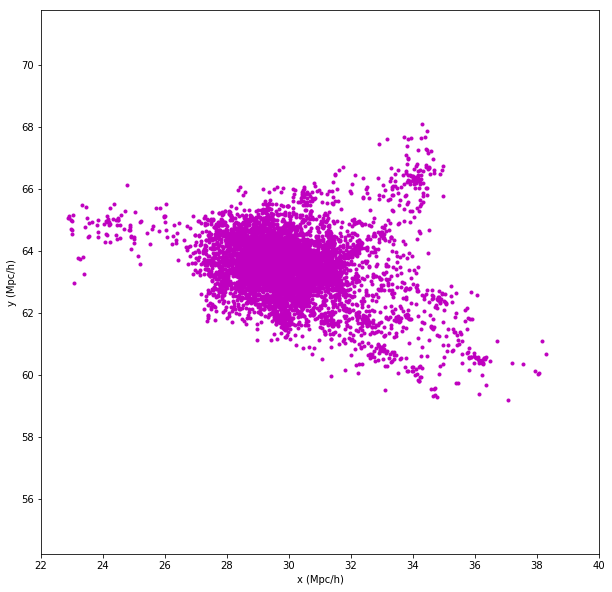

In [15]:
# Plot it! Let's hope it doesn't cross the box boundary!
plt.figure(figsize=(10,10))
plt.plot(pos[haloIDs,0],pos[haloIDs,1],'m.')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.axis('equal')

In [ ]:
# What else is around it?
subcube = N.where((pos[:,0] < N.max(pos[haloIDs,0])) & (pos[:,1] < N.max(pos[haloIDs,1])) & (pos[:,2] < N.max(pos[haloIDs,2])) \
                 & (pos[:,0] > N.min(pos[haloIDs,0])) & (pos[:,1] > N.min(pos[haloIDs,1])) & (pos[:,2] > N.min(pos[haloIDs,2])))[0]
plt.figure(figsize=(10,10))
plt.plot(pos[subcube,0],pos[subcube,1],'k.')
plt.plot(pos[haloIDs,0],pos[haloIDs,1],'m.')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')

In [ ]:
# What are the ORIGAMI tags of this halo?
orifile = '/home/idies/workspace/indra/origami/testrun/output_i200tmp_sf63/positions_i200tmp_sf63_test'
f = open(orifile,'rb')
npart = N.fromfile(f,N.int32,1)
tag = N.fromfile(f,N.int8,npart)
f.close()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(pos[haloIDs[tag[haloIDs] == 0],0],pos[haloIDs[tag[haloIDs]==0],1],'k.')
plt.plot(pos[haloIDs[tag[haloIDs] == 1],0],pos[haloIDs[tag[haloIDs]==1],1],'b.')
plt.plot(pos[haloIDs[tag[haloIDs] == 2],0],pos[haloIDs[tag[haloIDs]==2],1],'m.')
plt.plot(pos[haloIDs[tag[haloIDs] == 3],0],pos[haloIDs[tag[haloIDs]==3],1],'r.')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')

In [ ]:
# Looks like there are particles from nearby halos included! Does SUBFIND clean that up?
# TBD!
# (We may never know until we run SUBFIND again!!!)

In [ ]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pos[subcube,0],pos[subcube,1],pos[subcube,2],color='k',marker='.')
for c, i in [('k', 0), ('b',1), ('m',2), ('r',3)]:
    ax.scatter(pos[haloIDs[tag[haloIDs] == i],0],pos[haloIDs[tag[haloIDs]==i],1],\
               pos[haloIDs[tag[haloIDs] == i],2],marker='.',color=c)
#ax.scatter(pos[haloIDs,0],pos[haloIDs,1],pos[haloIDs,2],color='m',marker='o')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')